# **Partie 1 : Q learning**

Dans cette séance on testera l'algorithme de Q learning avec un environnement de simulation d'OpenAI gym.


### Quelques installations

Selon ce qui est déjà installé dans votre environnement de travail, vous aurez besoin de quelques librairies. 

In [2]:
%matplotlib nbagg

In [3]:
from IPython.display import clear_output
from ipywidgets import Output

In [4]:
!pip install ipywidgets gym box2d-py livelossplot pyglet 
!pip install scikit-learn numpy --upgrade
clear_output()

In [5]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import operator

import numpy as np

from tqdm.notebook import tqdm
from livelossplot import PlotLosses
import random

In [6]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab?", IN_COLAB)

In Colab? True


In [7]:
# Fonctions Pour L'Affichage

from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import display
from IPython.display import HTML

if IN_COLAB:
    !apt install xvfb python-opengl x11-utils -y
    !pip install pyvirtualdisplay pyglet
    # !pip install -q --upgrade ipython
    # !pip install -q --upgrade ipykernel
    from pyvirtualdisplay import Display
    global DISPLAY
    DISPLAY = Display(visible=False, size=(640, 480))
    DISPLAY.start()
    clear_output()
    
    def show_video():
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
        else: 
            print("Could not find video")
            
    def start_capture(env):
        env = Monitor(env, './video', force=True)
        return env
else:
    import matplotlib.pyplot as plt

    # Imports specifically so we can render outputs in Jupyter.
    #from JSAnimation.IPython_display import display_animation
    from matplotlib import animation
    from IPython.display import display_html
    from IPython.display import HTML

    class Notebook(object):    

        frames = []        

        @staticmethod
        def setup():
            Notebook.frames = []

        @staticmethod
        def record(env):
            Notebook.frames.append(env.render(mode = 'rgb_array'))

        @staticmethod
        def replay():
            """
            Displays a list of frames as a gif, with controls
            """
            plt.figure(figsize=(Notebook.frames[0].shape[1] / 72.0, Notebook.frames[0].shape[0] / 72.0), dpi = 72)
            patch = plt.imshow(Notebook.frames[0])
            plt.axis('off')

            def animate(i):
                patch.set_data(Notebook.frames[i])

            anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(Notebook.frames), interval=50)
            #display(display_animation(anim, default_mode='loop'))
            display_html(HTML(anim.to_html5_video()))   

        @staticmethod
        def log_progress(sequence, every=None, size=None, name='Episodes'):
            from ipywidgets import IntProgress, HTML, VBox
            from IPython.display import display

            is_iterator = False
            if size is None:
                try:
                    size = len(sequence)
                except TypeError:
                    is_iterator = True
            if size is not None:
                if every is None:
                    if size <= 200:
                        every = 1
                    else:
                        every = int(size / 200)     # every 0.5%
            else:
                assert every is not None, 'sequence is iterator, set every'

            if is_iterator:
                progress = IntProgress(min=0, max=1, value=1)
                progress.bar_style = 'info'
            else:
                progress = IntProgress(min=0, max=size, value=0)
            label = HTML()
            box = VBox(children=[label, progress])
            display(box)

            index = 0
            try:
                for index, record in enumerate(sequence, 1):
                    if index == 1 or index % every == 0:
                        if is_iterator:
                            label.value = '{name}: {index} / ?'.format(
                                name=name,
                                index=index
                            )
                        else:
                            progress.value = index
                            label.value = u'{name}: {index} / {size}'.format(
                                name=name,
                                index=index,
                                size=size
                            )
                    yield record
            except:
                progress.bar_style = 'danger'
                raise
            else:
                progress.bar_style = 'success'
                progress.value = index
                label.value = "{name}: {index}".format(
                    name=name,
                    index=str(index or '?')
                )
                
    def show_video():
        Notebook.replay()
        
    def start_capture(env):
        Notebook.setup()
        env = Monitor(env, './video', video_callable=False, force=True)
        old_step = env.step
        def wrapped_step(*args, **kwargs):
            Notebook.record(env)
            return old_step(*args, **kwargs)
        env.step = wrapped_step
        return env

## Découverte des environnements d'OpenAI Gym

Gym définit des mondes dans lesquels on peut avoir un agent qui agit sur l'environement, et avoir l'observation de certaines variables de cet environnement.

On utilisera l'environnement suivant, ou un module lunaire essaie d'atterrir en douceur sur un emplacement fixé:

In [8]:
# On charge un environnement 
env = gym.make("LunarLander-v2")

# on l'initialise sur un état de départ. 
env.reset()

array([-0.00266733,  1.4217777 , -0.27018088,  0.4825615 ,  0.00309749,
        0.06119994,  0.        ,  0.        ], dtype=float32)

Chaque environnement comprend un espace d'actions possibles par l'agent, qui est ici un module d'atterrissage lunaire doté de deux moteurs latéraux, et un moteur principal. L'agent peut aussi ne rien faire. 

In [9]:
# Espace des actions 
# Nop, fire left engine, main engine, right engine
ACTION_SPACE = ["NOP", "Left", "Main", "Right"]
print(env.action_space)
# on peut échantilloner une action au hasard
print(env.action_space.sample())

Discrete(4)
1


In [10]:
print(env.action_space.n)

4


L'environnement définit un certain nombre de variables observables.

In [11]:
# Espace des observations
# 0,1: Position X, Y
# 2,3: vitesse vx, vx
# 4: angle / vertical 
# 5: angle vitesse rotation 
# 6,7: capteur contact pied gauche/droit
OBS_SPACE = ["X Pos", "Y Pos", "V_X", "V_Y", "Angle", "Angular Speed", "Left Foot Contact", "Right Foot Contact"]

obs = env.reset()
print(obs.shape)
obs

(8,)


array([-0.00395117,  1.4162449 , -0.40022716,  0.2366473 ,  0.00458521,
        0.09065742,  0.        ,  0.        ], dtype=float32)

A chaque action faite par un agent, l'environnement informe sur le nouvel état, donne une récompense (prédéfinie et fixé pour chaque monde), et renvoie aussi une condition qui précise si la simulation est finie (crash ou atterrissage réussi). 

In [12]:
#faire une action, constater l'état suivant, reward etc
action = 1 # par exemple
observation, reward, done, info = env.step(action)
observation, reward, done, info

(array([-0.00796394,  1.4210026 , -0.40736026,  0.2114229 ,  0.01060334,
         0.12037404,  0.        ,  0.        ], dtype=float32),
 -0.5094607458714779,
 False,
 {})

## I) Ecrire une fonction de simulation qui fait une séquence d'action au hasard

et enregistre les récompenses et la trajectoire de chaque variable observée. 

L'appel à `wrap_env` sert à activer la capture vidéo.

In [13]:
# version à compléter
def random_sequence(env, nb, render=True, noprint=False):
        if render:
            # Activer la capture vidéo
            env = start_capture(env)
        # observation initiale
        observation = env.reset()
        # sauve les observations pour faire des stats
        trajectory = [observation]
        # somme des récompenses
        total = 0
        # récompense finale
        final = 0
        for t in range(nb):
            # compléter ici ...
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            total += reward
            trajectory += [observation]
            if done:
                if not noprint:
                    print("Episode finished after {} timesteps".format(t+1))
                final = reward #on voit la dernière reward pour savoir si on a gagné ou pas
                break
        env.close()
        trajectory = np.array(trajectory)
        return final, total, trajectory

In [14]:
final, total, trajectory = random_sequence(env, 200)
print("final reward =", final)
print("total reward =", total)

Episode finished after 64 timesteps
final reward = -100
total reward = -135.7566574870294


In [15]:
# lance la video des etats sauvegardés
show_video()

In [16]:
trajectory.shape

(65, 8)

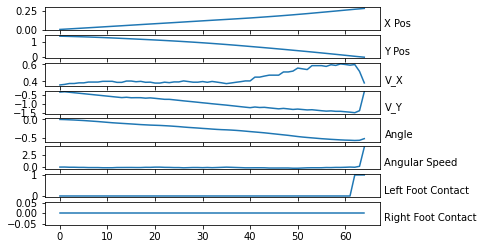

In [17]:
# On peut observer l'évolution des variables au cours de la simulation
%matplotlib inline
fig, axs = plt.subplots(8)
for i in range(8):
    axs[i].plot(trajectory[:,i])
    axs[i].yaxis.set_label_position("right")
    axs[i].set_ylabel(OBS_SPACE[i], rotation=0, labelpad=5, horizontalalignment='left')

## II) Q learning par discrétisation de l'espace des états

Pour pouvoir utiliser le Q-learning sur cet environnement, il faut limiter la taille de l'espace d'états, 
et donc discrétiser les valeurs continues de chaque variables pour n'avoir que quelques valeurs. 

Il faudra donc: 

- discrétiser l'espace des observations pour faire une Q-table: pour cela vous pouvez générer des simulations et regarder la distribution des valeurs
- implémenter un agent avec une table de Q gardant les valeurs des paires (états,actions)
     - implémenter le Q learning avec des paramètres controlant le processus (nb d'épisodes, longueur de chaque épisode, gamma, alpha, le facteur d'exploration au moins)
- tester différentes valeurs de paramètres pour améliorer l'apprentissage
- tester le modèle en simulant l'agent avec le modèle appris 


### a) Discrétisation manuelle
Pour discrétiser manuellement un espace continu on peut utiliser les fonctions de numpy: 
     
  - linspace pour découper un intervalle réel 
  - digitize pour assigner une valeur continue à un de ces intervalles

In [18]:
bornes = np.linspace(-1,1,11)
display_bornes = ["-∞"] + list(bornes) + ["+∞"]
print("bornes:", bornes)

x = -0.6578
i = np.digitize(x, bornes)
print(f"value {x} => [{display_bornes[i]} ; {display_bornes[i+1]}] = index {i}")

x = -0.888
i = np.digitize(x, bornes)
print(f"value {x} => [{display_bornes[i]} ; {display_bornes[i+1]}] = index {i}")

x = -2
i = np.digitize(x, bornes)
print(f"value {x} => [{display_bornes[i]} ; {display_bornes[i+1]}] = index {i}")

x = 4
i = np.digitize(x, bornes)
print(f"value {x} => [{display_bornes[i]} ; {display_bornes[i+1]}] = index {i}")

bornes: [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
value -0.6578 => [-0.8 ; -0.6] = index 2
value -0.888 => [-1.0 ; -0.8] = index 1
value -2 => [-∞ ; -1.0] = index 0
value 4 => [1.0 ; +∞] = index 11


In [19]:
# Si vous voulez le faire manuellement, sinon partie suivante ...

### a-bis) Discrétisation automatique
Pour discrétiser automatiquement un espace continu en fonction d'une distribution de valeurs, on peut utiliser un `KBinsDiscretizer` de la librairie `sklearn`. On doit d'abord collecter des échantillons de trajectoires en faisant tourner la simulation:

In [20]:
all_trajectories = [] # ensemble des trajectoires
all_rewards = [] # ensemble des récompenses moyennes
n_samples = 1000 # combien de simulations faire tourner
for _ in tqdm(range(n_samples)):
    final, total, trajectory = random_sequence(env, 100, render=False, noprint=True)
    all_trajectories.extend(trajectory)
    all_rewards.append(total/100)
    
all_trajectories = np.vstack(all_trajectories)
print("Mean total reward:", np.mean(all_rewards))


Mean total reward: -1.3962427359348408


In [21]:
all_trajectories.shape

(88168, 8)

In [22]:
# Pour que le KBinsDiscretizer ne pense pas que ces bins sont vides (peu de 1 dans ces deux composantes globalement)
all_trajectories[::2, [6,7]] = 0.0
all_trajectories[1::2, [6,7]] = 1.0

In [23]:
from sklearn.preprocessing import KBinsDiscretizer
#####################################################
# Hyperparamètre: Nombre de Bins (en fonction de la composante)
# Essayez différents nombres de bins
# les pieds (observations[6|7]) sont des booléens {0,1}, donc 2 bins seulement
N_Bins = [15]*2 + [10]*2 + [8,3] + [2,2] # seulement un exemple
print("Bin sizes =", N_Bins)
#####################################################

discretizer = KBinsDiscretizer(n_bins = N_Bins, # nombre de bins (intervalles) à construire       
                               encode = "ordinal", # renvoie l'indice de la "tranche" (comme digitize)
                               strategy = "quantile") # tout les bins auront le même nombre de points
# Attention: sklearn attend (et renvoie) des entrées en 2D, il faut donc faire un reshape(-1, 1)
# Fit sur la distribution de la i-ème composante de la trajectoire
discretizer.fit(all_trajectories)
# Pour l'affichage
discretizer_edges = [["-∞"] + list(edges[1:-1]) + ["+∞"] for edges in discretizer.bin_edges_]

Bin sizes = [15, 15, 10, 10, 8, 3, 2, 2]


In [24]:
discretizer_edges[1] # limites des bins pour Y Pos par exemple

['-∞',
 0.18131517469882966,
 0.393889331817627,
 0.5739815592765809,
 0.7291605472564697,
 0.8632254004478456,
 0.9813216090202332,
 1.0850609540939333,
 1.1756880044937135,
 1.253525114059448,
 1.3187419176101685,
 1.3709330320358277,
 1.4075927257537841,
 1.440393352508545,
 1.493448066711426,
 '+∞']

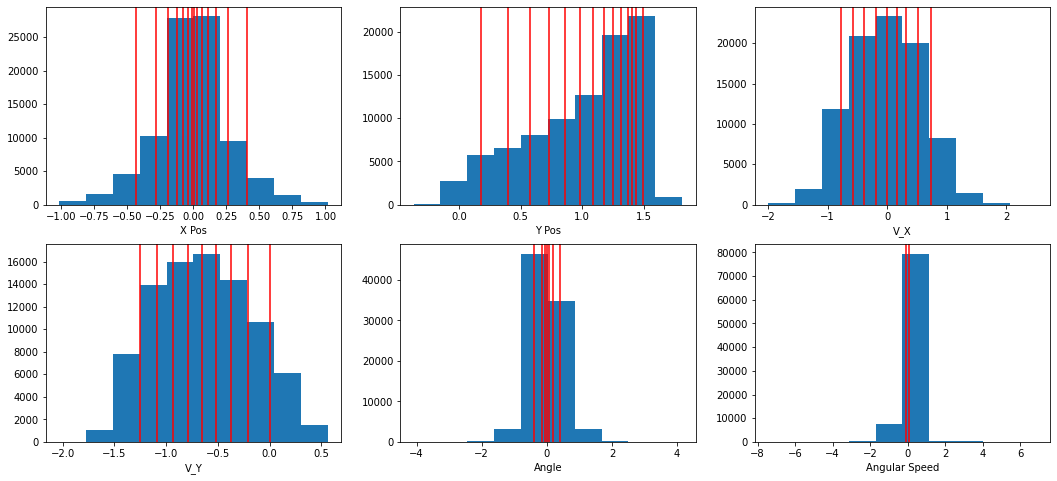

In [25]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

for i in range(6):
    axs[i//3,i%3].hist(all_trajectories[:,i],10)
    axs[i//3,i%3].set_xlabel(OBS_SPACE[i])
    for x in discretizer_edges[i][1:-1]:
        axs[i//3,i%3].axvline(x=x, color="r")

In [26]:
# Exemple:
obs = env.reset().reshape(1, -1)

obs[0,7] = 1.0
disc_obs = discretizer.transform(obs)
for i, (o, d) in enumerate(zip(obs.squeeze(), disc_obs.squeeze())):
    d = int(d)
    print(f"value {o} => [{discretizer_edges[i][d]} ; {discretizer_edges[i][d+1]}] = index {d}")

value 0.002880000974982977 => [-0.009331836551427832 ; 0.00829854961484671] = index 7
value 1.4061375856399536 => [1.3709330320358277 ; 1.4075927257537841] = index 11
value 0.291702538728714 => [0.1613425761461258 ; 0.32359065711498236] = index 6
value -0.21256190538406372 => [-0.37291714251041447 ; -0.20338437557220454] = index 7
value -0.0033304570242762566 => [-0.04873880138620734 ; 0.003658236120827496] = index 3
value -0.06607484817504883 => [-0.07669150829315186 ; 0.0914926752448082] = index 1
value 0.0 => [-∞ ; 0.5] = index 0
value 1.0 => [0.5 ; +∞] = index 1


In [27]:
# à compléter
class QLearner_LunarLander(object):
    def __init__(self, env, discretizer):
        """ Un exemple de constructeur (à modifier selon comment vous souhaitez discrétiser les états) """
        self.env = env
        self.discretizer = discretizer
        # Hyperparamètres stockés dans l'objet, pour simplifier
        self.alpha = .5
        self.gamma = .9993
        self.epsilon = 1
        self.min_epsilon = .01
        self.epsilon_decay = .9993
        # Le plus simple est de représenter Q par un dictionnaire de dictionnaire "dynamique"
        # associant un état à un dictionnaire associant une action à sa Q-valeur
        self.Q = {}

    def reset(self):
        """ Ré-initialise Q """
        self.Q = {}
                
    def discrete_state(self, real_state):
        """ Retourne l'état réel en paramètre sous forme discrétisée """
        disc_state = self.discretizer.transform(real_state.reshape(1,-1)).squeeze()
        return tuple(disc_state) # la clé d'un dictionnaire doit être un tuple (immuable)
    
    def get_Q(self, disc_state, action):
        """ Retourne la Q-valeur pour l'état discret et l'action donnée """
        return self.Q.get(disc_state,{}).get(action,0)
    
    def update_Q(self, state, action, reward, new_state):
        """ Met à jour Q en fonction de l'état courant, l'action, la récompense,
            le nouvel état, ainsi que la valeur courante de Q (get_Q) pour ..., 
            la meilleure Q-valeur (best_value) pour ..., alpha, et gamma 
        """
        # attention à gérer la structure du dictionnaire (clés manquantes, etc.)
        if not (state in self.Q and action in self.Q[state]):
            self.Q[state]={}
        self.Q[state][action] = (1-self.alpha)*self.get_Q(state,action)+self.alpha*(reward + self.gamma*self.best_value(new_state)) ### Pour rappel: la formule est dans votre cours ###
    
    def best_value(self, disc_state):
        """ Retourne la meilleure Q-valeur parmis toutes les actions pour un état discret donné,
            ou 0 sinon """
        if disc_state not in self.Q or len(self.Q[disc_state])==0:
          return 0
        return max(self.Q[disc_state].values())
            
    def best_action(self, disc_state):
        """ Retourne l'action avec la Q-valeur la plus grande parmis 
            toutes les actions pour un état discret donné, ou une action aléatoire sinon """
        if self.Q.get(disc_state,{}) != {}:
          return max(self.Q[disc_state].keys(),key=(lambda key : self.Q[disc_state][key]))
        else:
          return env.action_space.sample()


    def train(self, episodes = 1000, episode_max_length = 150, plot = False,
              **kwargs):
        """ Algorithme du Q-learning """
        # Modification éventuelle des hyperparamètres
        for k,v in kwargs.items():
            if hasattr(self, k):
                setattr(self, k, v)
        # Pour l'affichage des courbes
        if plot:
            with plot:
                liveplot = PlotLosses()
        total_rewards_training = [] # récompenses totales pour tout l'entraînement
        final_rewards_training = [] # récompenses finales pour tout l'entraînement
        # Algorithme
        for ep in tqdm(range(episodes)):
            # Etat initial
            real_state = env.reset()
            # Etat initial discrétisé
            disc_state = self.discrete_state(real_state)
            episode_reward = 0 # récompense totale pour l'épisode courant
            done = False # est-ce que l'épisode est fini
            i = 0 # indice de l'itération de simulation dans l'épisode
            # Boucle Episode :
            while i < episode_max_length:
                # Choisir dynamiquement une action en fonction du facteur epsilon :
                # Faire par exemple un tirage aléatoire dans [0;1] et comparer à epsilon
                nombre = random.random()
                # Si le tirage est en dessous de epsilon :
                if nombre < self.epsilon:
                #       => exploration (choix d'une action aléatoire)
                    action = env.action_space.sample()
                # Si le tirage est au dessus de epsilon :
                else:
                #       => exploitation (utiliser Q pour trouver la meilleure action dans l'état courant)
                    action = self.best_action(disc_state)
                # Récupérer le nouvel état du monde, la récompense, l'état de finalité, etc. en effectuant l'action choisie
                new_real_state, reward, done, _ = env.step(action)
                # Discétiser le nouvel état du monde
                new_disc_state = self.discrete_state(new_real_state)
                # Mettre à jour Q en passant l'état courant (discret), l'action effectuée,
                # la récompense obtenue, et le nouvel état (discret)
                self.update_Q(disc_state, action, reward, new_disc_state)
                # Accumuler la récompense
                episode_reward += reward*self.gamma
                # Mettre à jour les états en mémoire
                real_state = new_real_state
                disc_state = new_disc_state
                # Lorsque c'est fini:
                if done == True:
                    # Stocker la récompense finale
                    final_reward = reward
                    break
                # Timestep suivant
                i+=1
            # Optionel: Implémenter le epsilon-decay
            # A chaque fin d'épisode, multiplier epsilon par le facteur epsilon_decay,
            # tant que ce premier est supérieur au seuil minimale min_epsilon
            if self.epsilon > self.min_epsilon:
              self.epsilon*= self.epsilon_decay
            # Stockage des statisques globales
            total_rewards_training.append(episode_reward)
            final_rewards_training.append(final_reward)
            # Affichage des courbes
            if plot:
                with plot:
                    # Vous pouvez changer l'indice -5 ici pour avoir un lissage plus ou moins important de la courbe
                    liveplot.update({"Mean Total Reward": np.mean(total_rewards_training[-5:]), "Episode Total Reward":episode_reward})
                    if ep % 50 == 0: # Changer le modulo pour un rafraichissement plus/moins fréquent
                        liveplot.send()
        # Affichage des stats globales
        print(f"Mean Total Reward on all episodes: {np.mean(total_rewards_training)}")
        print(f"Mean Final Reward on all episodes: {np.mean(final_rewards_training)}")
        # Retour des scores
        return total_rewards_training

    def predict_action(self, real_state):
        """ Donne la meilleure action à prendre sachant l'état réel en paramètre """
        disc_state = self.discrete_state(real_state)
        action = self.best_action(disc_state)
        return action
    
    def simul_sequence(self, episode_max_length = 150, render = True):
        """ Effectue une simulation de l'agent avec le Q courant """
        env = self.env
        if render:
            # Activer la capture vidéo
            env = start_capture(env)
        # Observation initiale
        observation = env.reset()
        trajectory = [observation]
        total = 0 
        for t in range(episode_max_length):
            # Choisir la meilleure action possible en fonction de l'observation/état
            action = self.predict_action(observation)
            # Effectuer l'action
            observation, reward, done, info = env.step(action)
            trajectory.append(observation)
            # Accumuler la récompense
            total += reward
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                # Stocker la récompense finale
                final = reward
                break
        env.close()
        trajectory = np.array(trajectory)
        return final, total, trajectory

In [28]:
agent = QLearner_LunarLander(env, discretizer)

In [29]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

Output()

In [30]:
# Entrainer l'agent
# Essayez différents hyperparamètres
scores = agent.train(episodes=1000, episode_max_length=250,
                     epsilon = 0.2, alpha = 0.7, gamma = 0.9,
                     plot=PLOT_CONTEXT)


Mean Total Reward on all episodes: -183.2832901999529
Mean Final Reward on all episodes: -100.0


In [31]:
# Faire une simulation une fois le modèle entrainé, et espérer...
final, total, trajectory = agent.simul_sequence()

Episode finished after 96 timesteps


In [32]:
# Mouais... :P
show_video()

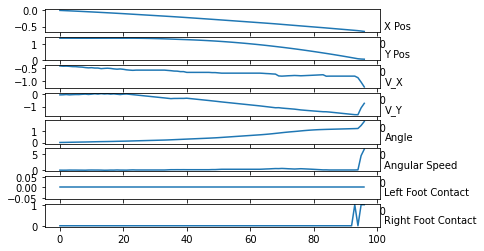

In [33]:
# On peut observer l'évolution des variables au cours de la simulation
%matplotlib inline
fig, axs = plt.subplots(8)
for i in range(8):
    axs[i].plot(trajectory[:,i])
    axs[i].yaxis.set_label_position("right")
    axs[i].set_ylabel(OBS_SPACE[i], rotation=0, labelpad=5, horizontalalignment='left')

## III) Evaluation du modèle et Conclusion Partie 1: 
On peut évaluer le succès du modèle en répétant les simulations: 

  - récompense moyenne sur N simulations après entrainement.
  - bonus: même chose divisée par nb d'échantillonages pour mesurer l'efficacité de l'entrainement.

Mais rien que de visu, vous devriez vous apercevoir que le modèle ne fonctionne pas très bien... **A votre avis, pourquoi?**

*Indice: Calculez la taille de l'espace d'état discrétisé, et comparez la à la taille de votre dictionnaire d'états Q après entraînement de l'agent.*

In [39]:
# Calculez la taille de l'espace d'état discrétisé (en fonction de N_Bins)
taille_espace_etat_disc = 15*2 + 10*2 + 8 + 3 + 2 + 2
print("Taille de l'espace d'état discrétisé : ",taille_espace_etat_disc)
# et comparer au Q de l'agent
taille_Q=0
for cle, valeur in agent.Q.items():
  for cle2, valeur2 in agent.Q[cle].items():
    taille_Q +=1
print("Taille de la Q table : ",taille_Q)

Taille de l'espace d'état discrétisé :  65
Taille de la Q table :  16941


**Comment pourrait-on améliorer l'agent ?**

Dans notre cas ici présent, nous ne pouvons avoir un espace d'état continu. En effet, le Q learning nécessite un espace discret et c'est pour cette raison que nous avons dû discretiser ce dernier. Comme nous avons pu le remarquer au travers de nos résultats, cette méthode présente de nombreuses limites. Cette discrétisation peut entrainer un mauvais choix d'action par notre agent car nous passons d'une infinité d'état à un nombre extrêmement réduit d'états discrets nous faisons perdre beaucoup d'information.

L'utilisation d'un autre type d'agent d'apprentissage par renforcement pouvant travailler avec un espace d'oberservation et d'action continu tel que le DDPG ou l'A3C pourrait s'avérer plus judicieux dans ce cas. L'utilisation d'un réseau de neurones pourrait également nous apporter de meilleurs résultats plutôt qu'une table de Q learning.

# **Partie 2 : DQN**

## I) Implémentation Naïve
**Attention :** Cette partie est très difficile, essayez si vous allez vite, mais sinon lisez et passez à la suite.

In [37]:
import tensorflow as tf
from tensorflow import keras

Dans cette partie on va donc essayer d'améliorer l'agent, en utilisant un/des modèle(s) neuronaux.

Dans un premier temps, vous pouvez essayer vous-même de dériver votre QLearner discrétisé en remplaçant le dictionnaire de dictionnaires Q par un réseau de neurones, qui associe à un vecteur d'observations/état en entrée, un vecteurs de Q-valeurs pour chaque action possible dans le jeu à cet état.

Voici un exemple de modèle que vous pourriez utiliser:

In [40]:
OBS_SPACE_SIZE = taille_espace_etat_disc # la taille de l'espace d'état discrétisé
ACTION_SPACE_SIZE = 1 # la taille de l'espace d'actions
N_NEURONS = 256 # le nombre de neurones pour les couches cachées

model = keras.Sequential([
            keras.layers.Dense(N_NEURONS, activation='relu',
                            input_dim=OBS_SPACE_SIZE),
            # Vous pouvez essayer avec différents nombre de couches cachées :
            # keras.layers.Dense(N_NEURONS, activation='relu'),
            # ...
            keras.layers.Dense(ACTION_SPACE_SIZE, activation='linear') # activation linéaire sur la couche de sortie ici :
            # les Q-valeurs ne sont en effet pas une distribution de probabilités, aucune raisons que leur somme fasse 1,
            # et pas de raison non-plus qu'elles aient un comportement non-linéaire
        ])

La question important est: comment et à quelle moment est-ce que l'on entraîne ce modèle ?

Regardez la formule de mise à jour de Q dans la version classique du Q-learning. Est-ce que cela vous rappelle quelque-chose ? (*Pensez à ce à quoi alpha correspond dans le Q-learning et dans la rétro-propagation des réseaux de neurones*).

Comment pourrait-on adapter cela en objectif pour le modèle neuronal ?

In [ ]:
# Essayez de dériver de votre classe
class DeepQLearner_LunarLander(QLearner_LunarLander):
    """ Implémente le Deep Q Learning """

    def __init__(self, env, discretizer, learning_rate = .0005):
        super().__init__(env, discretizer)
        self.learning_rate = learning_rate
        self.Q = ...
        # Rappelez vous bien de compiler le modèle
        # Je vous conseil ces paramètres: la loss "mse" est Mean Squared Errors
        # soit l'erreur quadratique moyenne
        adam = keras.optimizers.Adam(lr = self.learning_rate)
        self.Q.compile(loss='mse', optimizer=adam)

    # Ré-implémentez les méthodes qui ont besoin de l'être...

Notez par contre qu'utiliser `.fit` et `.predict` dans la boucle de simulation serait très lent (ces fonctions ne sont pas prévues pour être utilisées dans des boucles):
- A la place de `.fit(X,y)`, vous pouvez utiliser `.train_on_batch(X,y)` qui est plus rapide (par contre, comme son nom l'indique, `train_on_batch` considère que `X, y` sont déjà sous forme d'un batch, mais ici c'est ce que nous voulons car nous entraînons le modèle "en ligne", au fur et à mesure que l'on fait tourner la simulation, avec un batch de taille 1 à chaque fois).
- A la place de `model.predict(X)`, vous pouvez utiliser `model(X, training=False).numpy()` (attention par contre à bien respecter le format d'entrée du modèle).

In [ ]:
# Entrainer le modèle (sur peu d'époques, une dizaine par exemple, il se peut que cela soit très long)
# Juste pour voir si ça marche, contiuez à lire après

Refaites éventuellement des tests avec des simulations. Est-ce que cela semble marcher mieux ? Pourquoi à votre avis ?

## II) Implémentation avec *Experience Replay*

Vous avez potentiellement remarqué que l'approche naïve ne marche pas bien non plus. En effet, le problème est difficile à intuiter à priori: l'entraînement "en ligne", avec une seule Q-valeur à chaque fois, est non seulement très lent, mais en plus, les données d'apprentissage sont corrélées dans le temps (puisqu'elles proviennent de la simulation du jeu qui se fait timestep après timestep), alors qu'il faudrait qu'elles soient plus nombreuses et relativelement indépendantes et identiquement distribuées.

Pour ce faire, on peut utiliser la méthode de *l'Experience Replay*: pour faire simple, au lieu de donner directement les instances d'entraînement au modèle, on va les stocker dans une "mémoire" dans l'agent, puis, à chaque timestep, on va échantilloner aléatoirement un mini-batch de taille donnée de cette mémoire, et entraîner le modèle dessus.



Vous pouvez essayer de l'implémenter, mais c'est relativement dur, donc voici une implémentation déjà faite:

In [41]:
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random

experience_type = [('state', object),
                   ('action', int),
                   ('reward', float),
                   ('new_state', object),
                   ('done', bool)]

class DQLearner_LunarLander():
    """ Implémente le Deep Q Learning """
    def __init__(self, env,
                 learning_rate = .0005, memory_size = 5000,
                 minibatch_size = 32):
        self.env = env
        self.learning_rate = learning_rate
        self.memory_size = memory_size
        self.minibatch_size = minibatch_size
        
        self.a_space_size = self.env.action_space.n
        self.o_space_size = self.env.observation_space.shape[0]
        
        self.current_Q = self.make_model()
        self.episode_Q = self.make_model()
        self.memory = deque(maxlen = self.memory_size)
        
    def make_model(self):
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu',
                            input_dim=self.o_space_size),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(self.a_space_size, activation='linear')
        ])
        adam = keras.optimizers.Adam(lr = self.learning_rate)
        model.compile(loss='mse', optimizer=adam)
        return model
    
    def add_memory(self, state, action, reward, new_state, done):
        self.memory.append((state, action, reward, new_state, done))
        
    def update_current_Q(self):
        self.current_Q.set_weights(self.episode_Q.get_weights())
    
    def replay_experiences(self):
        # sample a minibatch from memory
        minibatch = np.array(random.sample(self.memory, self.minibatch_size),
                            dtype = experience_type)
        # get indices where the experience was not done
        not_done_indices = np.where(minibatch["done"] == False)
        # get target rewards from minibatch
        target_rewards = minibatch["reward"].copy()
        
        # if mini-batch contains non-done experiences, we have to apply gamma updates
        if len(not_done_indices) > 0:
            NS = np.vstack(minibatch["new_state"])
            # action predictions for the current Q model
            pred_next_actions_current_Q = self.serve_current_Q(NS).numpy()
            # action predictions for this episode's Q model
            pred_next_actions_episode_Q = self.serve_episode_Q(NS).numpy()

            # grab the action predictions for the not-done experiences
            pred_not_done = pred_next_actions_episode_Q[not_done_indices, :].squeeze()
            # grab the best actions indices from those
            best_actions = np.argmax(pred_not_done, axis=1)
            # grab the current Q values for those actions
            current_Q_for_best_actions = pred_next_actions_current_Q[not_done_indices, best_actions].squeeze()
            # add the gamma * current Q values for those actions
            target_rewards[not_done_indices] += np.multiply(0.9993, current_Q_for_best_actions)

        S = np.vstack(minibatch["state"])
        # compute episode predicted actions
        target_actions = self.serve_episode_Q(S).numpy()
        # update the appropriate values with the computed target rewards
        target_actions[range(len(minibatch)), minibatch["action"]] = target_rewards
        # fit the episode's model onto those target actions
        self.episode_Q.train_on_batch(S, target_actions)

    @tf.function 
    def serve_episode_Q(self, x):
        return self.episode_Q(x, training=False)

    @tf.function
    def serve_current_Q(self, x):
        return self.current_Q(x, training=False)

    def best_action(self, real_state):
        action = self.serve_episode_Q(real_state.reshape(1,-1)).numpy().argmax()
        return int(action)
    
    def train(self, alpha = .0005, gamma = .9993, epsilon = 1, min_epsilon = 0.01, epsilon_decay = 0.9993,
              episodes = 1000, episode_max_length = 150, plot = False):
        if plot:
            with plot:
                liveplot = PlotLosses()
        total_rewards_training = [] # total rewards for all episodes
        final_rewards_training = [] # final rewards for all episodes
        #  Q-learning Algorithm
        for ep in tqdm(range(episodes)):
            # Reset environment -> starting state
            real_state = self.env.reset()
            episode_reward = 0
            done = False
            i = 0
            # running an episode
            while i < episode_max_length:
                chance = np.random.rand(1)
                if chance<epsilon:
                    # take random action (exploration)
                    action = self.env.action_space.sample()
                else:
                    # take best action (exploitation)
                    action = self.best_action(real_state)

                #Get new state & reward from environment
                new_real_state, reward, done, _ = self.env.step(action)
                # Record memory
                self.add_memory(real_state, action, reward, new_real_state, done)
                # if enough experiences
                if len(self.memory) > self.minibatch_size:
                    # Experience Replay
                    self.replay_experiences()
                
                episode_reward += reward
                real_state = new_real_state
                
                if done == True:
                    final_reward = reward
                    # Update the Current Q model with the learned Episode Q model weights
                    self.update_current_Q()
                    break
                i+=1
            # epsilon decay
            if epsilon > min_epsilon and epsilon_decay:
                epsilon *= epsilon_decay
            
            total_rewards_training.append(episode_reward)
            final_rewards_training.append(final_reward)
            if plot:
                with plot:
                    liveplot.update({"Mean Total Reward": np.mean(total_rewards_training[-5:]), "Episode Total Reward":episode_reward})
                    if ep%2==0:
                        liveplot.send()

        print(f"Mean Total Reward on all episodes: {np.mean(total_rewards_training)}")
        print(f"Mean Final Reward on all episodes: {np.mean(final_rewards_training)}")
        # final Q table updated is in self.Q
        return total_rewards_training
    
    def simul_sequence(self, episode_max_length = 150, render = True):
        """
        sampling episode with prediction of best action
        """
        env = self.env
        if render:
            # Activer la capture vidéo
            env = start_capture(env)
        observation = env.reset()
        trajectory = [observation]
        total = 0
        final = 0
        for t in tqdm(range(episode_max_length)):
            action = self.best_action(observation)
            observation, reward, done, info = env.step(action)
            trajectory.append(observation)
            total += reward
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                final = reward
                break
        env.close()
        trajectory = np.array(trajectory)
        return final, total, trajectory

Vous pouvez essayer de l'entraîner un petit peu (c'est plus long encore), pour voir les courbes de tendances:

In [43]:
env = gym.make("LunarLander-v2")
# on l'initialise sur un état de départ. 
env.reset()
deepQ = DQLearner_LunarLander(env)

In [44]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

Output()

In [45]:
# Diminuez le nombre d'episodes si c'est trop lent sur votre machine
# Avec 250 episodes, on commence à apercevoir la tendance générale normalement
scores = deepQ.train(episodes=250, plot=PLOT_CONTEXT)


Mean Total Reward on all episodes: -150.58726735514023
Mean Final Reward on all episodes: -100.0


Pour gagner du temps, j'ai entraîné ce modèle pendant 1h30 (5000 épisodes) pour vous. Exécuter ces cellules pour charger les poids appris dans le modèle.

In [46]:
url = "https://drive.google.com/uc?export=download&id=10Stakliwyhsv3DCLc7rfABrEvkLeMfVQ"

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.extractall()

In [47]:
Q = keras.models.load_model("Q.h5")

deepQ = DQLearner_LunarLander(env)
deepQ.current_Q = Q
deepQ.episode_Q = Q
deepQ.current_Q.load_weights("Q.h5")
deepQ.episode_Q.load_weights("Q.h5")

Regardons ce que cela donne :)

Ca ne marche pas à tout les coups évidemment, essayez plusieurs fois, puis refaites des simulations pour calculer les performances.

In [54]:
# Essayez différentes valeurs de episode_max_length... 
# Est-ce que vous remarquez quelque-chose d'étrange ?
final, total, trajectory = deepQ.simul_sequence(episode_max_length=300)
print("final reward =", final)
print("total reward =", total)


final reward = 0
total reward = 101.1098703693199


Nous remarquons que plue la valeur de episode_max_length est grande et plus la total reward sera faible.

In [55]:
show_video()

In [ ]:
# Calculer les performances en faisant plusieurs simulations
...

Vous devriez remarquer que mon agent a un comportement assez étrange (jouez avec le paramètre `episode_max_length` pour la simulation). 

A votre avis, à quoi est-ce dû ? 

Quelle erreur ai-je commise en paramétrant l'entraînement ? (*Voir le code de la classe plus haut, en particulier les paramètres liés à la simulation*).

Comment pourrait-on régler le problème (sans repartir de zéro nécessairement) ?